in shapes: (1, 30, 30, 30, 1) (3, 3, 3, 1, 1)
ConvDimensionNumbers(lhs_spec=(0, 4, 1, 2, 3), rhs_spec=(4, 3, 0, 1, 2), out_spec=(0, 4, 1, 2, 3))
out shape:  (1, 30, 30, 30, 1)


/var/folders/26/nngplyxn1rjgjb3k0lpsth380000gn/T/ipykernel_5514/4259837294.py:45: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/var/folders/26/nngplyxn1rjgjb3k0lpsth380000gn/T/ipykernel_5514/4259837294.py:50: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection=

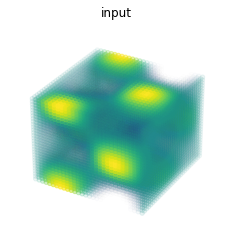

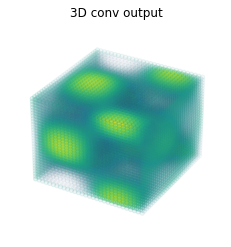

In [62]:
import matplotlib.pyplot as plt
from scipy import misc
import jax.scipy as jsp
from jax import random, lax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import figure


# Random 3D kernel - HWDIO layout
kernel = jnp.array([
  [[0, 0,  0], [0,  1,  0], [0,  0,   0]],
  [[0, -1, 0], [-1, 0, -1], [0,  -1,  0]], 
  [[0, 0,  0], [0,  1,  0], [0,  0,   0]]], 
  dtype=jnp.float32)[:, :, :, jnp.newaxis, jnp.newaxis]

# 3D data - NHWDC layout
data = jnp.zeros((1, 30, 30, 30, 1), dtype=jnp.float32)
x, y, z = np.mgrid[0:1:30j, 0:1:30j, 0:1:30j]
data += (jnp.sin(2*x*jnp.pi)*jnp.cos(2*y*jnp.pi)*jnp.cos(2*z*jnp.pi))[None,:,:,:,None]

print("in shapes:", data.shape, kernel.shape)
dn = lax.conv_dimension_numbers(data.shape, kernel.shape,
                                ('NHWDC', 'HWDIO', 'NHWDC'))
print(dn)

out = lax.conv_general_dilated(data,    # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1,1), # window strides
                               'SAME',  # padding mode
                               (1,1,1), # lhs/image dilation
                               (1,1,1), # rhs/kernel dilation
                               dn)      # dimension_numbers
print("out shape: ", out.shape)

# Make some simple 3d density plots:
from mpl_toolkits.mplot3d import Axes3D
def make_alpha(cmap):
  my_cmap = cmap(jnp.arange(cmap.N))
  my_cmap[:,-1] = jnp.linspace(0, 1, cmap.N)**3
  return mpl.colors.ListedColormap(my_cmap)
my_cmap = make_alpha(plt.cm.viridis)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=data.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('input')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=out.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('3D conv output');

In [11]:
import PIL
#load a grayscaled image from data/mad1001.png
img = PIL.Image.open('../../data/mad2995.png')
#get dimensions and print
print(img.size)
#convert to gray scale
img = img.convert('L')
#preview
img.show()

(512, 512)


In [16]:
#convert image to jax array
img = jnp.asarray(img)
#get the first few values jax array (note that the image is now a 3D array)
print(img[0,:])



[ 14  12  11  10  11  14  17  18  21  22  23  34  41  38  94 140 152 182
 148 112 131 157 176 209 228 228 212 213 232 226 224 226 221 241 231 226
 235 237 241 232 234 234 234 234 232 228 227 224 232 233 228 235 229 232
 233 228 227 231 235 230 232 232 232 225 223 240 228 230 235 238 239 233
 235 234 234 234 234 233 231 228 229 239 231 230 234 228 235 230 228 228
 235 215 183 154 167 171 167 167 167 165 182 190 192 190 185 174 133  96
  92  77  69  48  33  26  20  16  15  18  20  20  21  21  21  22  23  25
  43  62  80 118 155 173 169 158 114  83  42  19  15   6   9  19  70  62
  12   3   1   5   7   7   6   7  18 108 235 211 183 153 134 126 134 145
 186 205 216 221 223 231 238 236 235 232 214 227 244 230 245 241 245 245
 242 241 235 235 230 227 231 229 249 248 239 238 237 241 241 235 231 231
 226 219 213 201 192 184 176 159 147 135 114 103  86  82  82  73  55  61
  56  43  43  43  40  37  38  37  32  27  27  30  33  35  37  38  38  38
  36  32  32  34  34  34  35  35  34  33  33  33  3

In [179]:
import os
import glob

num_images = 100
start_frame = 10200

#get the first 100 sequential images from the data dir
img_paths = sorted(glob.glob('../../data/*.png'))[start_frame:start_frame+num_images]
#load all images into a single multi-channel array
for i, img_path in enumerate(img_paths):
    img = PIL.Image.open(img_path)
    img = img.convert('L')
    #resize to 100x100
    img = img.resize((100,100))
    img = jnp.asarray(img)
    #set set the left pixel of (num_images - i) to values of 0
    img = img.at[:,:-(num_images-i)].set(0)
#add another dimension to the array for concatenation
    img = img[:,:,None]
    if img_paths[0] is img_path:
        images = img
    else:
        images = jnp.concatenate((images, img), axis=-1)

#print images dimensions
print(images.shape)

(100, 100, 100)


In [167]:
#invert y axis
# images = jnp.flip(images, axis=)

In [180]:
x, y, z = np.mgrid[0:images.shape[0], 0:images.shape[1], 0:images.shape[2]]
#rescale the data to be between 0 and 1
images = images/255

In [181]:
#flip the y axis
images = jnp.flip(images, axis=0)

/var/folders/26/nngplyxn1rjgjb3k0lpsth380000gn/T/ipykernel_5514/1443146823.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0.92, 'input')

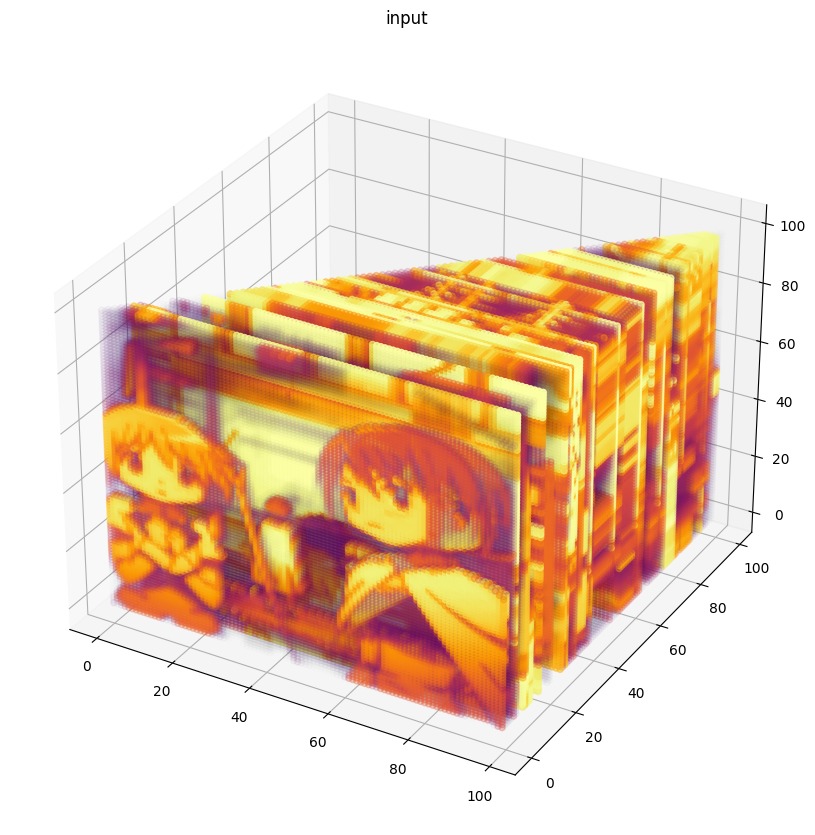

In [197]:
def make_alpha(cmap):
  my_cmap = cmap(jnp.arange(cmap.N))
  my_cmap[:,-1] = jnp.linspace(0, 1, cmap.N)**2
  return mpl.colors.ListedColormap(my_cmap)


my_cmap = make_alpha(plt.cm.inferno)
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(100)
ax = fig.gca(projection='3d')
#plot 3d scatter plot image tensor
ax.scatter(y.ravel(), z.ravel(), x.ravel(), c=images.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('input')

In [204]:
from matplotlib import animation
def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('fig.gif', writer=animation.PillowWriter(fps=20))

In [202]:
ani.save('fig-10.gif', writer=animation.PillowWriter(fps=10))

KeyboardInterrupt: 